In [1]:
#pip install git+https://github.com/stardist/augmend.git

In [1]:
%load_ext tensorboard

# import torch and other libraries
import os
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import trange

from tqdm import tqdm 
from skimage.measure import regionprops
from skimage.segmentation import clear_border
from tifffile import imread
from pathlib import Path
from collections import Counter
import json
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
import utils
from augmend import Augmend, Elastic, Identity, FlipRot90, Rotate

In [2]:
root = '../'

augment = True
use_gputools = True
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')

# Data

In [3]:
X = sorted(Path(f'{root}/data/images/').glob('*.tif'))
Y = sorted(Path(f'{root}/data/masks/').glob('*.tif'))
json_files = sorted(Path(f'{root}/data/labels/').glob('*.json'))

for x,y,j in zip(X,Y,json_files):
    print('------')
    print(x)
    print(y)
    print(j)

X = list(map(imread,X))
print(X[0].shape)
X = [utils.normalize(x[:, 0, :, :]) for x in X]
Y = list(map(imread,Y))
Y = [clear_border(y) for y in Y]

C = []
for el in json_files:
    with open(el, 'r') as fp:
        class_dict = json.load(fp)
        C.append({int(k):int(v) for k,v in class_dict.items() if int(k) > 0})

counts = Counter()
classes = set()
for c in C:
    counts = counts + Counter(c.values())
    for k, item in c.items():
        classes.add(item)
print( classes)
n_classes = len(classes) 
print(n_classes)
print(counts)


------
../data/images/fish2_nasal_15-75z.tif
../data/masks/fish2_nasal_15-75z.tif
../data/labels/fish2_nasal_15-75z_corrected.json
------
../data/images/fish2_nasal_20-80z.tif
../data/masks/fish2_nasal_20-80z.tif
../data/labels/fish2_nasal_20-80z.json
------
../data/images/fish2_nasal_25-85z.tif
../data/masks/fish2_nasal_25-85z.tif
../data/labels/fish2_nasal_25-85z.json
------
../data/images/fish2_temporal_10-70z.tif
../data/masks/fish2_temporal_10-70z.tif
../data/labels/fish2_temporal_10-70z.json
------
../data/images/fish2_temporal_20-81z.tif
../data/masks/fish2_temporal_20-81z.tif
../data/labels/fish2_temporal_20-81z.json
------
../data/images/fish2_temporal_5-65z.tif
../data/masks/fish2_temporal_5-65z.tif
../data/labels/fish2_temporal_5-65z_corrected.json
(61, 2, 330, 300)
{1, 2, 3, 4, 5, 6, 7, 8}
8
Counter({2: 442, 1: 282, 3: 233, 4: 201, 5: 63, 7: 20, 8: 17, 6: 14})


In [4]:
#Remove NaN from dict
counts.pop(8)
n_classes = n_classes - 1
print(counts)

Counter({2: 442, 1: 282, 3: 233, 4: 201, 5: 63, 7: 20, 6: 14})


In [5]:
# class_weights (as classes are quite inbalanced)

_counts = np.array(tuple(counts[i] for i in range(1,n_classes+1)))
inv_freq = 1./np.sqrt(1+_counts)
inv_freq = (inv_freq/inv_freq.min()).round(3)
class_weights = tuple(inv_freq)
print(class_weights)
print(n_classes)

(1.251, 1.0, 1.376, 1.481, 2.631, 5.434, 4.593)
7


In [ ]:
#Test out some centroid stuff!
print(Y[0].shape)
y0 = regionprops(Y[0])
#print(len((y0)))
#print(y0[0].centroid)
#print(y0[1].centroid)

for r in range (len(y0)):
    i,j,k = y0[r].centroid
    #print(i)
    #print(centroid)

In [94]:
for r in regionprops(Y[0]):
    center = r.centroid


In [95]:
x0 = X[0]
for r in regionprops(Y[0]):
    x = x0[r.slice].copy()

In [96]:
x0 = x[0]
print(x0)

[[0.24386503 0.2582822  0.28834355 ... 0.06809816 0.05460123 0.05245399]
 [0.25582823 0.26809815 0.27883434 ... 0.08619632 0.07822086 0.06196319]
 [0.22760735 0.24693252 0.23957056 ... 0.11104295 0.11441718 0.08619632]
 ...
 [0.08619632 0.07147239 0.0797546  ... 0.09079754 0.08588957 0.08650307]
 [0.1        0.09846625 0.09601227 ... 0.12116564 0.11871166 0.09601227]
 [0.12822086 0.12085889 0.11840491 ... 0.12576687 0.13343558 0.11533742]]


In [24]:

xdim, ydim, zdim = 48, 48, 24
xhalf = xdim // 2
yhalf = ydim // 2
zhalf = zdim // 2

#print(xhalf,yhalf,zhalf)

#Test out some centroid stuff!
#print(Y[0].shape)
y0 = regionprops(Y[0])
#print(len(y0))
x0 = X[0]
xs = []
for r in range (len(y0)):
    k,j,i = y0[r].centroid
    
    i = int(i)
    j = int(j)
    k = int(k)
    #print(i,j,k)
    
    #print(x0.shape)
    
    x = x0[(slice(k-zhalf, k+zhalf, None), slice(j-yhalf, j+yhalf, None), slice(i-xhalf, i+xhalf, None))].copy()
    
    xs.append(x)
    print(x.shape)
    #print(x)
    #print(x.shape)
    #xs.append(x)


(24, 48, 48)
(24, 48, 48)
(24, 48, 48)
(24, 48, 48)
(24, 48, 48)
(24, 48, 48)
(24, 48, 48)
(24, 48, 48)
(24, 48, 48)
(24, 48, 48)
(24, 48, 48)
(24, 48, 48)
(24, 48, 48)
(24, 48, 48)
(24, 48, 48)
(24, 48, 48)
(24, 48, 48)
(24, 48, 48)
(24, 48, 48)
(24, 48, 48)
(24, 48, 48)
(24, 48, 48)
(24, 48, 48)
(24, 48, 48)
(23, 48, 48)
(24, 48, 48)
(24, 48, 48)
(24, 48, 48)
(24, 48, 48)
(24, 48, 48)
(24, 48, 48)
(24, 48, 48)
(24, 48, 48)
(24, 48, 48)
(24, 48, 48)
(24, 48, 48)
(0, 48, 36)
(24, 48, 48)
(24, 48, 48)
(24, 48, 48)
(24, 48, 45)
(24, 48, 48)
(24, 48, 48)
(24, 48, 48)
(24, 48, 48)
(24, 48, 48)
(24, 48, 48)


In [6]:
# create crops 

def generate_crops(xs,ys,cs, shape = (48, 96, 96)):
    X, Y = [], []
    for x0, y0, c in tqdm(zip(xs,ys,cs), total=len(xs)):
        counter = 0
        for r in regionprops(y0):
            mask = y0[r.slice]==r.label
            k,j,i = r.centroid
            k = int(k)
            j = int(j)
            i = int(i)
            zdim, ydim, xdim = shape
            zhalf = zdim // 2
            yhalf = ydim // 2
            xhalf = xdim // 2
            #Remove small spots
            if (mask.sum() < 100):
                continue
            #x = x0[r.slice].copy()
            x = x0[(slice(k-zhalf, k+zhalf, None), slice(j-yhalf, j+yhalf, None), slice(i-xhalf, i+xhalf, None))].copy()
            #remove the line below if you want to keep image raw.
            #x[~mask] = 0
            x = utils.pad_to_shape(x, shape, mode='constant')
            mask = utils.pad_to_shape(x, shape, mode='constant')
            y = c[r.label]-1
            #Add this to try the other resnet idea
            x = np.stack([x, mask])
            X.append(x)
            Y.append(y) 
            counter = counter + 1
    X = np.stack(X)
    Y = np.stack(Y)
    return X,Y

X_crop, Y_crop = generate_crops(X, Y, C)

#print(f'training: {len(X_train)} validation: {len(X_valid)}')

100%|██████████| 6/6 [00:02<00:00,  2.44it/s]


In [8]:
print(len(X_crop))
print(len(Y_crop))

387
387


In [8]:
# Remove the "7" crops, which are NaN
X_clean = []
Y_clean = []


for x,y in zip(X_crop, Y_crop):
     if y != 7:
            X_clean.append(x)
            Y_clean.append(y)

X_crop = np.stack(X_clean)
Y_crop = np.stack(Y_clean)

print(len(X_crop))
print(len(Y_crop))

print(X_crop.shape)
print(X_crop[0].shape)
print(Y_crop.shape)
    


387
387
(387, 2, 48, 96, 96)
(2, 48, 96, 96)
(387,)


In [10]:
assert len(X_crop) > 1, "not enough training data"
rng = np.random.RandomState(11)
ind = rng.permutation(len(X_crop))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_valid, Y_valid = [X_crop[i] for i in ind_val]  , [Y_crop[i] for i in ind_val]
X_train, Y_train = [X_crop[i] for i in ind_train], [Y_crop[i] for i in ind_train]

X_valid = np.stack(X_valid)
Y_valid = np.stack(Y_valid)
X_train = np.stack(X_train)
Y_train = np.stack(Y_train)




print('number of images: %3d' % len(X_crop))
print('- training:       %3d' % len(X_train))
print('- validation:     %3d' % len(X_valid))

#for j in range(len(Y)):
#    print(len(np.unique(Y[j]))-1, len(list(C[j].keys())))


#for j in range(len(Y_trn)):
#    print(len(np.unique(Y_trn[j]))-1, len(list(C_trn[j].keys())))
   # print(np.unique(Y_trn[j]))
    #print(list(C_trn[j].keys()))

number of images: 387
- training:       329
- validation:      58


In [23]:
print(X_train[0].shape)
print(X_train[0][0].shape)
print(X_train[0][1].shape)
#it's a two channel image

X_train[0][0].shape
print(Y_train.shape)
X_train[0].reshape

(2, 48, 96, 96)
(48, 96, 96)
(48, 96, 96)
(329,)


<function ndarray.reshape>

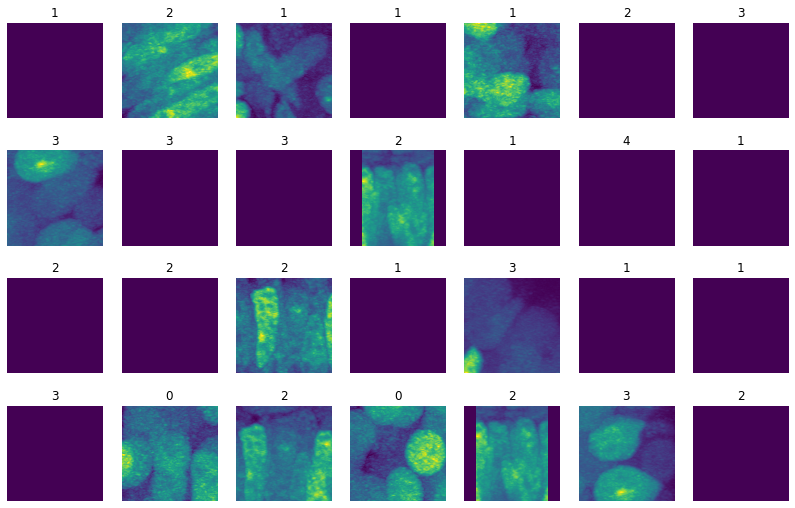

In [26]:

#ch1 = X_train[1]
n_plot = 28
plt.figure(figsize=(14,9))
for i, ind in enumerate(np.random.choice(range(len(X_train)),n_plot)):
    plt.subplot(4,n_plot//4,i+1)
    plt.imshow (np.max(X_train[ind][0], 0))
    plt.axis('off')
    plt.title(Y_train[ind])


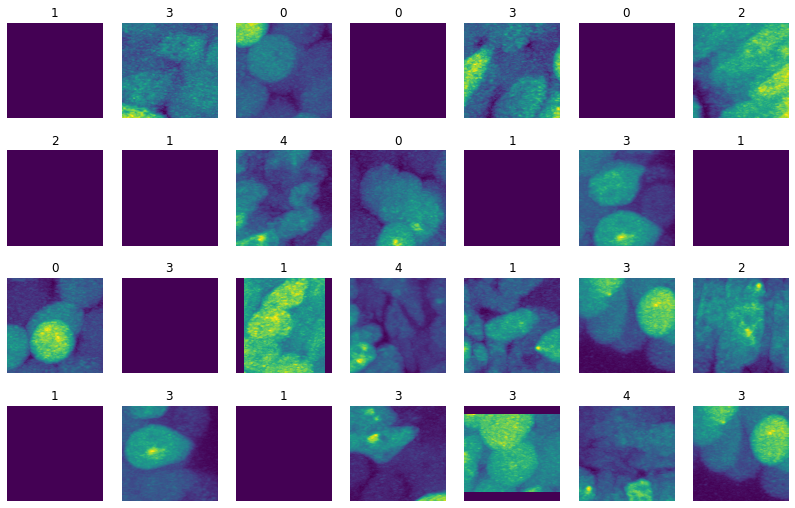

In [29]:


n_plot = 28
plt.figure(figsize=(14,9))
for i, ind in enumerate(np.random.choice(range(len(X_train)),n_plot)):
    plt.subplot(4,n_plot//4,i+1)
    plt.imshow(np.max(X_train[ind][1], 0))
    plt.axis('off')
    plt.title(Y_train[ind])


# Model (small resnet)

In [12]:
class ResnetBlock3D(torch.nn.Module):
    def __init__(self, n_in ,n_out,stride = 1):
        super().__init__()
        norm_layer = nn.BatchNorm3d
        
        self.conv1 = torch.nn.Conv3d(n_in,n_out,3,stride=stride,padding=1,bias=False)        
        self.bn1 = norm_layer(n_out)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = torch.nn.Conv3d(n_out,n_out,3,stride=1,padding=1,bias=False)        
        self.bn2 = norm_layer(n_out)
        
        if stride==1 and n_in==n_out:
            self.after_ident = torch.nn.Identity()
        else:
            self.after_ident = torch.nn.Sequential(
                        torch.nn.Conv3d(n_in, n_out, kernel_size=1, stride=stride),
                        torch.nn.BatchNorm3d(n_out))

    def forward(self, x):
        identity = self.after_ident(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out
    
    
class SimpleResnet3D(torch.nn.Module):
    def __init__(self, n_in=1,n_classes=8, n_levels=3, n_inter=64):
        super().__init__()
        self.blocks = torch.nn.ModuleList(tuple(ResnetBlock3D(n_in if i==0 else n_inter, n_inter, stride=2) for i in range(n_levels)))
        self.pool = torch.nn.AdaptiveAvgPool3d((1,1,1))
        self.fc = torch.nn.Linear(n_inter, n_classes)
        
    def forward(self,x):
        for block in self.blocks:
            x = block(x) 
            
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
        

In [13]:
model = SimpleResnet3D(n_in=1, n_classes=7)

model.to(device)


# test the input/output

x = torch.ones((5,1,48,96,96)).to(device)
model(x).shape

torch.Size([5, 7])

# Training

In [14]:
data_train = TensorDataset(torch.tensor(X_train[:,np.newaxis]).float(),torch.tensor(Y_train).long())
data_val = TensorDataset(torch.tensor(X_valid[:,np.newaxis]).float(),torch.tensor(Y_valid).long())

aug = Augmend()

if augment:
    aug.add([FlipRot90(axis=(2,3)),Identity()])
#    aug.add([Rotate(axis=(2,3)),Identity()])
#     aug.add([Elastic(grid=10, amount=2, order=0, axis=(2,3), use_gpu=use_gputools),Identity()])


data_train = aug.torch_wrap(data_train)


In [15]:
X_train.shape

(329, 48, 96, 96)

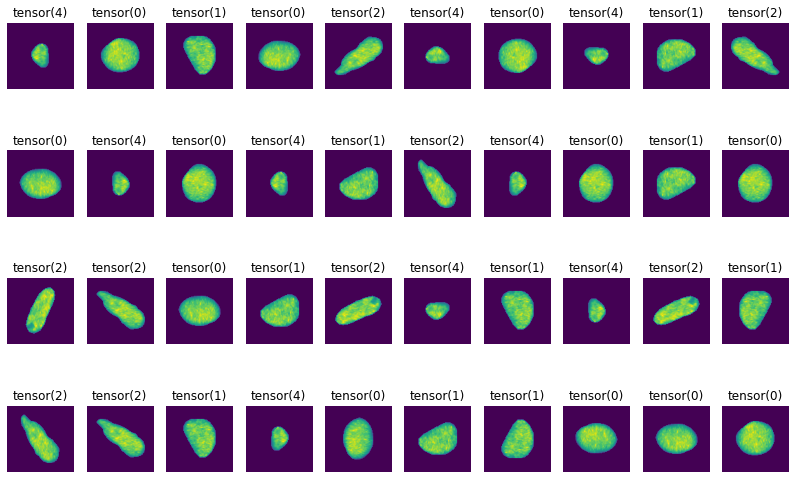

In [16]:
n_plot = 40
plt.figure(figsize=(14,9))
for i, ind in enumerate(np.random.choice(range(len(X)),n_plot)):
    x,y = data_train[ind]
    plt.subplot(4,n_plot//4,i+1)
    plt.imshow(np.max(x.numpy(),(0,1)))
    plt.axis('off')
    plt.title(y)

In [17]:
loader_train = DataLoader(data_train, batch_size=8, shuffle=True)
loader_val = DataLoader(data_train, batch_size=8, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)


In [18]:
utils.run_training(model, optimizer, loader_train, loader_val, device=device, 
                   name=f'resnet_aug_{augment}', n_epochs=100, class_weights=class_weights)

Validation acc 0.9300911854103343: 100%|██████████| 100/100 [11:22<00:00,  6.82s/it]


'best_checkpoint_resnet_aug_True.tar'

In [19]:
next(iter(loader_train))[0].shape

torch.Size([8, 1, 48, 96, 96])

In [28]:

%tensorboard --logdir=runs/resnet_aug_True

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 5, in <module>
    from tensorboard.main import run_main
  File "/home/9e72f40240c6f440/.local/lib/python3.8/site-packages/tensorboard/main.py", line 27, in <module>
    from tensorboard import default
  File "/home/9e72f40240c6f440/.local/lib/python3.8/site-packages/tensorboard/default.py", line 33, in <module>
    from tensorboard.plugins.audio import audio_plugin
  File "/home/9e72f40240c6f440/.local/lib/python3.8/site-packages/tensorboard/plugins/audio/audio_plugin.py", line 23, in <module>
    from tensorboard import plugin_util
  File "/home/9e72f40240c6f440/.local/lib/python3.8/site-packages/tensorboard/plugin_util.py", line 24, in <module>
    import markdown
  File "/home/9e72f40240c6f440/.local/lib/python3.8/site-packages/markdown/__init__.py", line 29, in <module>
    from .core import Markdown, markdown, markdownFromFile  # no

In [24]:
pip install zipp

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [25]:
import tensorboard

In [26]:
tensorboard.__file__

'/home/9e72f40240c6f440/.local/lib/python3.8/site-packages/tensorboard/__init__.py'